In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import netCDF4 as nc

$$
    \phi=(x-x_c)^TQ(x-x_c)=R_{eff}^2 \quad\quad\quad\quad \psi_0=\psi(x_c,y_c)
$$
$$
\begin{align}
    \psi &= \psi_0\exp\left\{-\phi/R_c^2\right\} 
    \\
    &\approx \psi_0\left(1-\psi/R_c^2\right)
    \\
    &\equiv \psi_0 + \left\{Q_{11}(x-x_x)^2+2Q_{12}(x-x_c)(y-y_c)+Q_{22}(y-y_c)^2\right\}
    \end{align}
$$

$$
\begin{align}
    Q_{11}=-\frac{\psi_0}{R_c^2}q_{11}, && Q_{12}=-\frac{\psi_0}{R_c^2}q_{12}, && Q_{22}=-\frac{\psi_0}{R_c^2}q_{22}
\end{align}
$$

### ROMS Case

In [2]:
fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h =  np.transpose(dataset.variables['h'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))[150, 150, :]
def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2
dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])
x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')
with open('/srv/scratch/z5297792/Chapter2/dic_sample.pkl', 'rb') as f:
    dic_sample = pickle.load(f)
sample_eddies = list(dic_sample.keys())
df_eddies = pd.read_pickle("/srv/scratch/z5297792/Chapter2/df_eddies_meso.pkl")


#### Extract Data

In [3]:
def extract_eddy_domain(eddy, t, dic_sample, df_eddies,
                        mask_rho, X_grid, Y_grid,
                        k=0, radius=200,
                        uv_dir='/srv/scratch/z5297792/Climatology/u_v'):
    eddy = f'Eddy{eddy}'
    day = list(dic_sample[eddy].keys())[t]
    # pull out the snapshot DataFrame
    df_snapshot = dic_sample[eddy][day]
    # figure out which file to load
    sample_id = int(eddy[4:])
    day_num   = int(day[3:])
    row = df_eddies.loc[
        (df_eddies['ID']==sample_id)&
        (df_eddies['Day']==day_num)
    ].iloc[0]
    fname   = row['fname']
    fnumber = fname[-8:-3]
    # load and mask raw u/v
    u_raw = np.load(f'{uv_dir}/u_{fnumber}.npy')
    v_raw = np.load(f'{uv_dir}/v_{fnumber}.npy')
    u_raw = np.where(u_raw>1e30, np.nan, u_raw).astype(float)
    v_raw = np.where(v_raw>1e30, np.nan, v_raw).astype(float)
    # find the time index
    with nc.Dataset(fname) as ds:
        ocean_time = ds.variables['ocean_time'][:].data/86400
        rho = np.transpose(ds.variables['rho'], axes=(3, 2, 1, 0))
        rho = np.flip(rho, axis=2)
    t_rel = np.where(ocean_time==day_num)[0][0]
    # pick out eddy parameters
    data = df_snapshot.iloc[k]
    x0, y0, Q, depth = data.x, data.y, data.Q, data.Depth
    q11, q12, q22    = Q[0,0], Q[1,0], Q[1,1]
    # print(f'q11: {q11}, q12: {q12}, q22: {q22}')
    # slice out the k,t_rel snapshot and re‐mask
    u = np.where(mask_rho, u_raw[:,:,k,t_rel], np.nan)
    v = np.where(mask_rho, v_raw[:,:,k,t_rel], np.nan)
    rho = np.squeeze(rho[:,:,:,t_rel])
    # bounding‐box around the eddy centre
    mask_dom = np.hypot(X_grid-x0, Y_grid-y0) <= radius
    i_inds, j_inds = np.where(mask_dom)
    i_min, i_max = i_inds.min(), i_inds.max()
    j_min, j_max = j_inds.min(), j_inds.max()
    # extract the rectangular subarray
    u_eddy = u[i_min:i_max+1, j_min:j_max+1]
    v_eddy = v[i_min:i_max+1, j_min:j_max+1]
    X_eddy = X_grid[i_min:i_max+1, j_min:j_max+1]
    Y_eddy = Y_grid[i_min:i_max+1, j_min:j_max+1]
    x_eddy = X_eddy[:,0]
    y_eddy = Y_eddy[0,:]
    # Density
    rho_eddy = rho[i_min:i_max+1, j_min:j_max+1]
    z_r = np.load('/srv/scratch/z5297792/z_r.npy')
    z_r = -np.transpose(z_r, (1, 2, 0))[i_min:i_max+1, j_min:j_max+1, :]
    return {
        'u': u_eddy,
        'v': v_eddy,
        'X': X_eddy,
        'Y': Y_eddy,
        'x': x_eddy,
        'y': y_eddy,
        'q11': q11,
        'q12': q12,
        'q22': q22,
        'x0': x0,
        'y0': y0,
        'Depth': depth,
        'rho': rho_eddy,
        'z_r': z_r
    }

def extract_transect_center(u, v, X, Y, x0, y0, r=30):
    x, y = X[:,0], Y[0,:]
    # find grid point closest to the eddy center
    dis = np.hypot(X - x0, Y - y0)
    ic, jc = np.unravel_index(np.argmin(dis), dis.shape)
    # horizontal transect (constant y = y[jc])
    x_mask = np.abs(x - x0) < r
    x1 = x[x_mask]
    y1 = np.full_like(x1, y[jc])
    u1 = u[x_mask, jc]
    v1 = v[x_mask, jc]
    # vertical transect (constant x = x[ic])
    y_mask = np.abs(y - y0) < r
    y2 = y[y_mask]
    x2 = np.full_like(y2, x[ic])
    u2 = u[ic, y_mask]
    v2 = v[ic, y_mask]
    # find intersection point
    points1 = set(zip(x1, y1))
    points2 = set(zip(x2, y2))
    common = points1 & points2
    if not common:
        raise ValueError("No common points found.")
    center_x, center_y = common.pop()
    # compute offsets
    xx = x1 - center_x
    yy = y2 - center_y
    return {
        'x1': x1, 'y1': y1, 'u1': u1, 'v1': v1,
        'x2': x2, 'y2': y2, 'u2': u2, 'v2': v2,
        'center_x': center_x, 'center_y': center_y,
        'xx': xx, 'yy': yy
    }

In [4]:
df = pd.DataFrame(columns=['Cyc'])
for eddy in sample_eddies:
    eddy = int(eddy[4:])
    cyc = df_eddies[df_eddies['ID']==eddy].iloc[0]['Cyc']
    df.loc[len(df)] = {'Cyc': cyc}
df.index = sample_eddies
df

,Cyc
Eddy2749,AE
Eddy8,AE
Eddy2504,AE
Eddy896,AE
Eddy1394,CE
Eddy382,CE
Eddy1967,CE
Eddy926,CE


In [5]:
eddy = 1967
t = 10

# Domain Data
dic_eddy_domain = extract_eddy_domain(eddy, t, dic_sample, df_eddies, mask_rho, X_grid, Y_grid)
ue = dic_eddy_domain['u']
ve = dic_eddy_domain['v']
Xe = dic_eddy_domain['X']
Ye = dic_eddy_domain['Y']
q11e = dic_eddy_domain['q11']
q12e = dic_eddy_domain['q12']
q22e = dic_eddy_domain['q22']
x0e = dic_eddy_domain['x0']
y0e = dic_eddy_domain['y0']
Depthe = dic_eddy_domain['Depth']
# DOPIOE Data
dic_eddy_transect = extract_transect_center(ue, ve, Xe, Ye, x0e, y0e, r=40)
x1e = dic_eddy_transect['x1']
y1e = dic_eddy_transect['y1']
u1e = dic_eddy_transect['u1']
v1e = dic_eddy_transect['v1']
xxe = dic_eddy_transect['xx']
x2e = dic_eddy_transect['x2']
y2e = dic_eddy_transect['y2']
u2e = dic_eddy_transect['u2']
v2e = dic_eddy_transect['v2']
yye = dic_eddy_transect['yy']


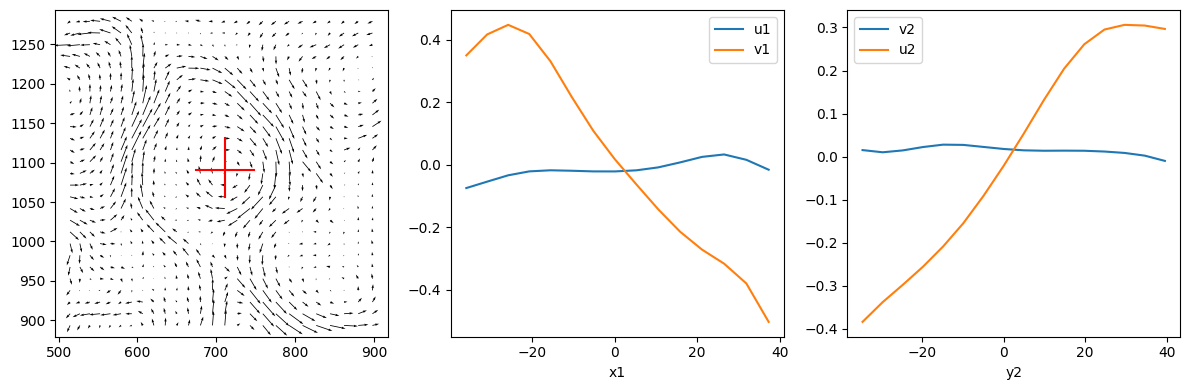

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
spacing = 3
axs[0].quiver(Xe[::spacing, ::spacing], Ye[::spacing, ::spacing], ue[::spacing, ::spacing], ve[::spacing, ::spacing])
# axs[0].scatter(x0e, y0e)
axs[0].plot(x1e, y1e, 'r'); axs[0].plot(x2e, y2e, 'r')
axs[0].axis('equal')

axs[1].plot(xxe, u1e, label='u1'); axs[1].plot(xxe, v1e, label='v1')
axs[1].set_xlabel('x1')
axs[1].legend()

axs[2].plot(yye, v2e, label='v2'); axs[2].plot(yye, u2e, label='u2')
axs[2].set_xlabel('y2')
axs[2].legend()

plt.tight_layout()
plt.show()

In [7]:
def espra_Rc(xi, yi, ui, vi, x0, y0, q11, q12, q22):
    from scipy.optimize import least_squares
    if np.any(np.isnan(ui)):
        return np.nan, np.nan

    # q11, q22 = np.abs(q11), np.abs(q22)

    def residuals(params, x, y, u_i, v_i):
        Rc, psi0 = params

        Q11 = - psi0 / Rc**2 * q11
        Q12 = - psi0 / Rc**2 * q12
        Q22 = - psi0 / Rc**2 * q22

        phi = Q11*(x - x0)**2 + 2*Q12*(x - x0)*(y - y0) + Q22*(y - y0)**2
        phi_x = 2*Q11*(x - x0) + 2*Q12*(y - y0)
        phi_y = 2*Q22*(y - y0) + 2*Q12*(x - x0)

        factor = - 1 / Rc**2
        exp_term = np.exp(factor * phi)

        u = -factor * phi_y * exp_term * psi0
        v = factor * phi_x * exp_term * psi0

        return np.concatenate([(u - u_i), (v - v_i)])

    # Initial guesses: Rc=10, psi0=1
    params_init = [5.0, 1.0]
    bounds_lower = [1e-6, -np.inf]   # Rc ≥ 1, scale ≥ 0.01
    bounds_upper = [50.0, np.inf] # Rc ≤ 20, scale ≤ 100

    result = least_squares(residuals, params_init, bounds=(bounds_lower, bounds_upper), args=(xi, yi, ui, vi))
    Rc_opt, psi0_opt = result.x
    return Rc_opt, psi0_opt
    

In [8]:
xi = np.concatenate([x1e, x2e])
yi = np.concatenate([y1e, y2e])

ui = np.concatenate([u1e, u2e])
vi = np.concatenate([v1e, v2e])

Rc, psi0 = espra_Rc(xi, yi, ui, vi, x0e, y0e, q11e, q12e, q22e)
print(Rc, psi0)

4.828013779937936 23.951469290300384


In [13]:
def gaussian_vel_reconstruction(x0, y0, q11, q12, q22, Rc, psi0):

    # q11, q22 = np.abs(q11), np.abs(q22)

    Q11 = - psi0 / Rc**2 * q11
    Q12 = - psi0 / Rc**2 * q12
    Q22 = - psi0 / Rc**2 * q22

    # Q11 = q11
    # Q12 = q12
    # Q22 = q22
    
    width = 200
    x = np.linspace(x0-width, x0+width, 51)
    y = np.linspace(y0-width, y0+width, 51)
    X, Y = np.meshgrid(x, y)
    
    dx, dy = X - x0, Y - y0
    
    phi   = Q11*dx**2 + 2*Q12*dx*dy + Q22*dy**2
    phi_x = 2*Q11*dx  + 2*Q12*dy
    phi_y = 2*Q22*dy  + 2*Q12*dx
    
    # 5) build Gaussian streamfunction with that R
    exp_term = np.exp(-phi / Rc**2)
    psi_x = -phi_x / Rc**2 * exp_term
    psi_y = -phi_y / Rc**2 * exp_term
    
    u = -psi_y * psi0
    v =  psi_x * psi0

    return u, v, X, Y

u_dopioe, v_dopioe, X_dopioe, Y_dopioe = gaussian_vel_reconstruction(x0e, y0e, q11e, q12e, q22e, Rc, psi0)

from scipy.interpolate import griddata
points = np.column_stack((X_dopioe.ravel(), Y_dopioe.ravel()))
values_v, values_u = v_dopioe.ravel(), u_dopioe.ravel()
v1_dopioe = griddata(points, values_v, (x1e, y1e), method='linear')
u1_dopioe = griddata(points, values_u, (x1e, y1e), method='linear')
v2_dopioe = griddata(points, values_v, (x2e, y2e), method='linear')
u2_dopioe = griddata(points, values_u, (x2e, y2e), method='linear')


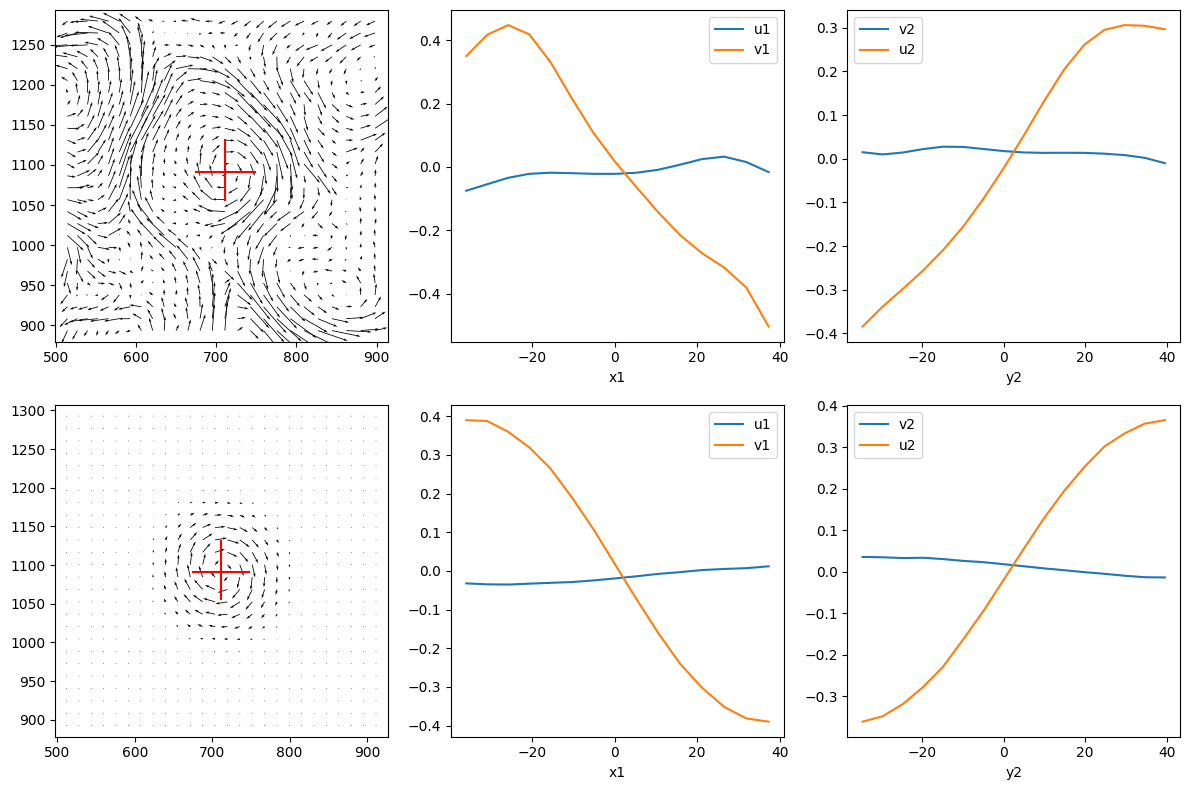

In [18]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
quiv_scale = 10 

spacing = 3
axs[0,0].quiver(Xe[::spacing, ::spacing], Ye[::spacing, ::spacing],
                ue[::spacing, ::spacing], ve[::spacing, ::spacing], scale=quiv_scale)
axs[0,0].plot(x1e, y1e, 'r'); axs[0,0].plot(x2e, y2e, 'r')
axs[0,0].axis('equal')

axs[0,1].plot(xxe, u1e, label='u1'); axs[0,1].plot(xxe, v1e, label='v1')
axs[0,1].set_xlabel('x1')
axs[0,1].legend()

axs[0,2].plot(yye, v2e, label='v2'); axs[0,2].plot(yye, u2e, label='u2')
axs[0,2].set_xlabel('y2')
axs[0,2].legend()

spacing = 2
axs[1,0].quiver(X_dopioe[::spacing, ::spacing], Y_dopioe[::spacing, ::spacing],
                u_dopioe[::spacing, ::spacing], v_dopioe[::spacing, ::spacing], scale=quiv_scale)
axs[1,0].plot(x1e, y1e, 'r'); axs[1,0].plot(x2e, y2e, 'r')
axs[1,0].axis('equal')

axs[1,1].plot(xxe, u1_dopioe, label='u1'); axs[1,1].plot(xxe, v1_dopioe, label='v1')
axs[1,1].set_xlabel('x1')
axs[1,1].legend()

axs[1,2].plot(yye, v2_dopioe, label='v2'); axs[1,2].plot(yye, u2_dopioe, label='u2')
axs[1,2].set_xlabel('y2')
axs[1,2].legend()

plt.tight_layout()
plt.show()

In [ ]:
dx1 = x1e - x0e  # shape (n,)
dy1 = y1e - y0e  # shape (n,)
Q = np.array([[q11e, q12e], [q12e, q22e]])  # shape (2, 2)
# Stack dx and dy into a (2, n) array
d1 = np.stack([dx1, dy1], axis=0)  # shape (2, n)
# Compute the quadratic form: d.T @ qmat @ d, for each column
Reff1 = np.einsum('ij,jk,ik->i', d1.T, Q, d1.T)
cs1 = np.hypot(u1e, v1e)

dx2 = x2e - x0e  # shape (n,)
dy2 = y2e - y0e  # shape (n,)
# Stack dx and dy into a (2, n) array
d2 = np.stack([dx2, dy2], axis=0)  # shape (2, n)
# Compute the quadratic form: d.T @ qmat @ d, for each column
Reff2 = np.einsum('ij,jk,ik->i', d2.T, Q, d2.T)
cs2 = np.hypot(u2e, v2e)

fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].plot(Reff1, cs1, label='1')
axs[0].plot(Reff2, cs2, label='2')
axs[0].legend()

# Model
phi = q11e*(x1e - x0e)**2 + 2*q12e*(x1e - x0e)*(y1e - y0e) + q22e*(y1e - y0e)**2
phi_x = 2*q11e*(x1e - x0e) + 2*q12e*(y1e - y0e)
phi_y = 2*q22e*(y1e - y0e) + 2*q12e*(x1e - x0e)

# psi0 = 100
# Rc = 5

Vaz = np.abs(psi0) / Rc**2 * np.sqrt(phi_x**2 + phi_y**2) * np.exp(- phi / Rc**2)

axs[1].plot(Reff1, Vaz)

plt.tight_layout()
plt.show()


#### Sample

In [22]:
# for eddy in dic_sample.keys():

eddy = 'Eddy1967'

t = 20

day = list(dic_sample[eddy].keys())[t]

df = dic_sample[eddy][day]

df['Rc'] = np.nan
df[r'$\psi_0$'] = np.nan

for k in df['z']:
    
    # Domain Data
    dic_eddy_domain = extract_eddy_domain(int(eddy[4:]), t, dic_sample, df_eddies, mask_rho, X_grid, Y_grid, k=k)
    ue = dic_eddy_domain['u']
    ve = dic_eddy_domain['v']
    Xe = dic_eddy_domain['X']
    Ye = dic_eddy_domain['Y']
    q11e = dic_eddy_domain['q11']
    q12e = dic_eddy_domain['q12']
    q22e = dic_eddy_domain['q22']
    x0e = dic_eddy_domain['x0']
    y0e = dic_eddy_domain['y0']
    # DOPIOE Data
    dic_eddy_transect = extract_transect_center(ue, ve, Xe, Ye, x0e, y0e, r=40)
    x1e = dic_eddy_transect['x1']
    y1e = dic_eddy_transect['y1']
    u1e = dic_eddy_transect['u1']
    v1e = dic_eddy_transect['v1']
    x2e = dic_eddy_transect['x2']
    y2e = dic_eddy_transect['y2']
    u2e = dic_eddy_transect['u2']
    v2e = dic_eddy_transect['v2']
    
    xi = np.concatenate([x1e, x2e])
    yi = np.concatenate([y1e, y2e])
    ui = np.concatenate([u1e, u2e])
    vi = np.concatenate([v1e, v2e])
    
    Rce, psi0e = espra_Rc(xi, yi, ui, vi, x0e, y0e, q11e, q12e, q22e)

    df.at[k, 'Rc'] = Rce
    df.at[k, r'$\psi_0$'] = psi0e



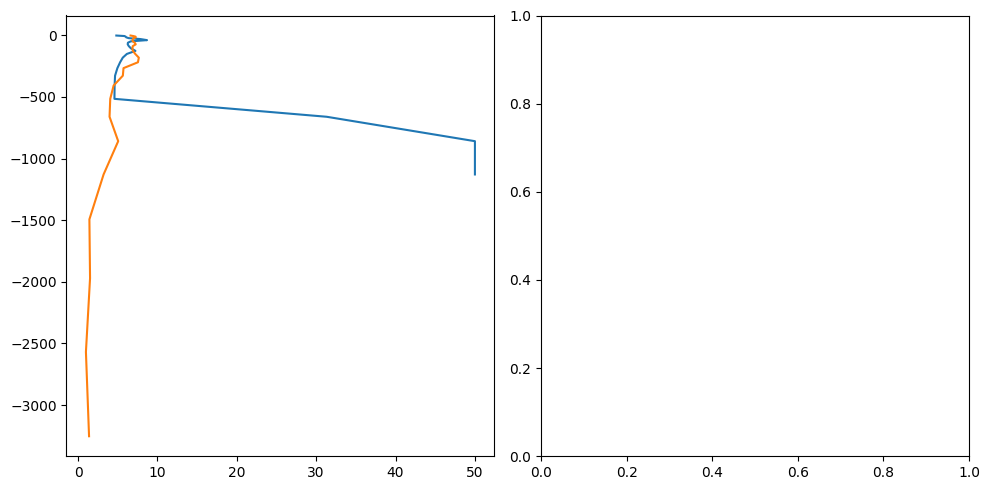

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
for t in range(len(dic_sample[eddy])):
    dff = dic_sample[eddy][list(dic_sample[eddy].keys())[t]]
    if 'Rc' in dff.columns:
        # dff = dff[dff['Rc']<=40]
        axs[0].plot(dff['Rc'], dff['Depth'])


plt.tight_layout()
plt.show()